<a href="https://colab.research.google.com/github/koad7/Embeddings_NER/blob/main/Embeddings_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.2 MB/s eta 0:00:00


In [ ]:
import numpy as np

# Embeddings

In many cutting-edge NLP models, contextual embeddings have demonstrated superior performance compared to traditional embeddings like Word2Vec or GloVe. Contextual embeddings consider the context of the word in the sentence, which can help to understand the semantics more accurately. Some examples of such embeddings are BERT, ELMo, and GPT embeddings.

BERT embeddings, in particular, are powerful because they consider the context of a word in both directions (left-to-right and right-to-left). Given the complexity of this model - which includes clustering, Gaussian Hidden Markov Model (Gaussian-HMM), Deep Autoencoding Gaussian Mixture Model (DAGMM), and reinforcement learning for refinement - BERT embeddings might provide a rich feature set that the model could benefit from.

It's important to note that the choice of embeddings could also be influenced by factors like the language of the text (as different embeddings may perform better with different languages), the computational resources available, and the specific requirements of the task.

For the best results, we will consider experimenting with different types of embeddings to see which works best for your specific use case and dataset.

#### Bert

In [ ]:
from transformers import BertModel, BertTokenizer
import numpy as np
import torch

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

# Model is in evaluation mode (i.e., dropout layers aren't applied)
model.eval()


paragraph = '''Police launched a battery investigation
Yahoo has confirmed that Spears filed a police report after the confrontation, which apparently identifies Spurs director of team security Damian Smith as the person who allegedly backhanded the singer.

"On July 5, 2023, at approximately 11 p.m., LVMPD officers responded to a property in the 3700 block of Las Vegas Boulevard regarding a battery investigation," a police spokesperson said on Thursday. "The incident has been documented on a police report and no arrest or citations have been issued."

A criminal investigation is being conducted. TMZ, meanwhile, has reported the case will "likely" be sent to the district attorney's office.

An eyewitness backs up Spears's version
A man who saw everything go down at the Aria hotel told TMZ he saw Spears approach Wembanyama. Purportedly, she leaned in and said, "Excuse me, sir ... excuse me, sir." Spears apparently touched Wembanyama's back and that's when the witness claimed to see a Spurs security guard hit her in the face causing Spears's sunglasses to fly off.

Sam Asghari watched the whole thing go down, too
Spears's husband blasted the "coward" who allegedly hit his wife, but said Wembanyama isn't at fault.

"The violent behavior of an out-of-control security guard should not cast a shadow on the accomplishment of a great young man on the rise. The blame should fall on the coward who did this, the people who hired him without proper vetting, and a systemic culture of disregard for women within sports and entertainment," he wrote, in part, on Instagram.

"I can't imagine a scenario where an unarmed female fan showing any kind of excitement or appreciation for a celebrity would cause her to be physically assaulted, much less being hit in the face for tapping someone on the shoulder," he added.'''

# Tokenize the paragraph
tokens = tokenizer.tokenize(paragraph)

# Map the token strings to their vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)

# Convert indexed tokens to a PyTorch tensor
tokens_tensor = torch.tensor([indexed_tokens])

# Create an attention mask
segments_ids = [1] * len(tokens)

# Convert inputs to PyTorch tensors
segments_tensors = torch.tensor([segments_ids])

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

# Predict hidden states features for each layer
with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]  # The third output consists of hidden states

# `hidden_states` has shape [13 x 1 x sequence_length x 768]
# Select the embeddings from the second to last layer
# Token embeddings are created by summing the last four layers
token_embeddings = torch.stack(hidden_states[-4:], dim=0)
token_embeddings = torch.sum(token_embeddings, dim=0)

# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=0)

# List to store word embeddings
word_embeddings_list = []

for i in range(len(tokens)):
    word_embeddings_list.append(token_embeddings[i].numpy())

# Convert list of embeddings into a numpy array
embeddings_matrix = np.array(word_embeddings_list)





Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Clustering

In [ ]:
from sklearn.cluster import KMeans

# Define the number of clusters
num_clusters = 2

# Perform k-means clustering on the 2D embeddings
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings_matrix)

# Get cluster assignments for each word
cluster_assignments = kmeans.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Visualizing KMEANS

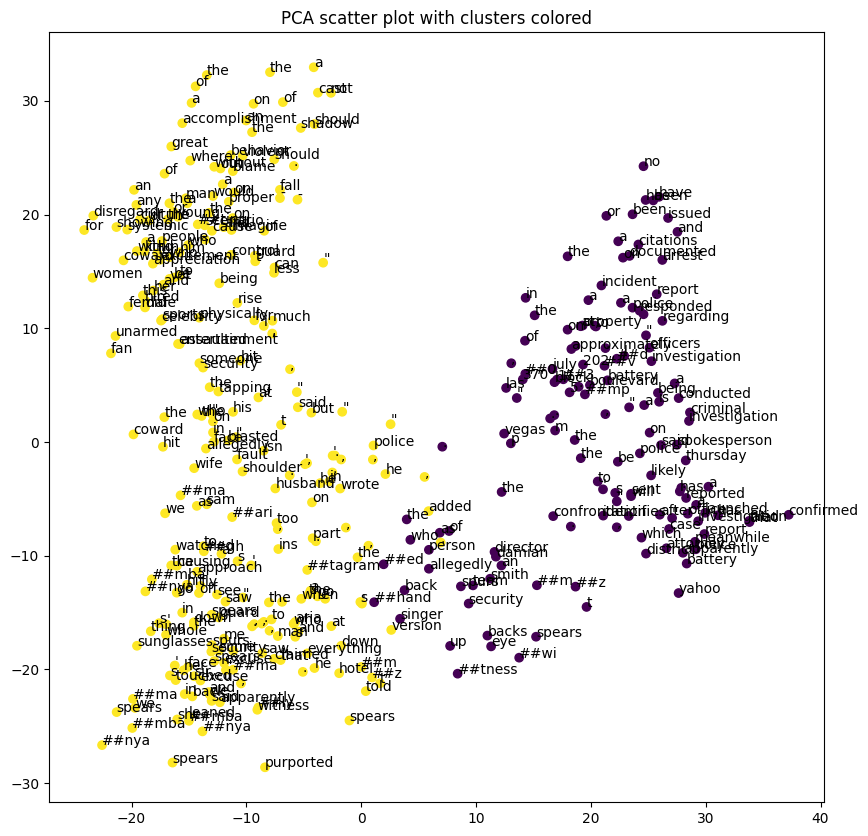

In [ ]:
from transformers import BertModel, BertTokenizer
import numpy as np
import torch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA to reduce the dimensionality to 2
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(embeddings_matrix)

# Create a scatter plot of the reduced features, colored by their clusters
plt.figure(figsize=(10, 10))
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    c=cluster_assignments,  # This should have the same length as the number of points
    cmap='viridis'
)

# annotate the points on the scatter plot with their corresponding word
for i, word in enumerate(tokens):
    plt.annotate(word, (reduced_features[i, 0], reduced_features[i, 1]))

plt.title("PCA scatter plot with clusters colored")
plt.show()


In [ ]:
len(reduced_features)

12

In [ ]:
len(sentences)

12